In [4]:
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
import os
import openai
openai.api_key = os.getenv("OPENAI_API_KEY")
reply = openai.Completion.create(
  engine="text-davinci-002",
  prompt="In a comma-separated list, give me ten one-word nouns related to dog:",
  max_tokens=2000
)
reply

<OpenAIObject text_completion id=cmpl-5DTl6DGcVSzSsJWQcAkJ7gcuPivmj at 0x2b6785e71450> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "text": "\n\ncollar, leash, food, water, toys, treats, Obedience, tracking, herding, show."
    }
  ],
  "created": 1653894340,
  "id": "cmpl-5DTl6DGcVSzSsJWQcAkJ7gcuPivmj",
  "model": "text-davinci-002",
  "object": "text_completion"
}

In [6]:
import re

In [8]:
import numpy as np

In [24]:
import time

min_time_between_calls = 1.01

time_previous_call = time.perf_counter_ns()

def calc_children_concepts(concept, prompt="In a comma-separated list, give me ten one-word objects related to '{}':"):
    global time_previous_call
    time_call = time.perf_counter_ns()
    
    dt = (time_call-time_previous_call)/1000000000
    if dt < min_time_between_calls:
        time.sleep(min_time_between_calls-dt)
    time_previous_call = time_call
    
    prompt = prompt.format(concept)
    response = openai.Completion.create(
        engine="text-davinci-001",
        prompt=prompt,
        temperature=0,
        max_tokens=50,
    )
    
    response = response["choices"][0].text
    response = response.strip().replace(' ', '')
    
    response = response.replace(',', '\n')
    response = re.sub(r"\d+\.", "", response)
    response = response.lower()
    
    return np.array(response.replace(' ', '').split('\n'))


calc_children_concepts('dog')


array(['pooch', 'canine', 'mutt', 'pup', 'retriever', 'shepherd',
       'rottweiler', 'doberman', 'jackrussell', 'labrador'], dtype='<U11')

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import clip
from PIL import Image

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [7]:
# image = preprocess(Image.open("dog.jpg")).unsqueeze(0).to(device)

In [8]:
with torch.no_grad():
    # image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    # logits_per_image, logits_per_text = model(image, text)
    # probs = logits_per_image.softmax(dim=-1).cpu().numpy()

# print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]
# image_features.shape, text_features.shape

NameError: name 'text' is not defined

In [9]:
def calc_text_features(texts, normalize=True):
    x = clip.tokenize(texts).to(device)
    with torch.no_grad():
        x = model.encode_text(x).detach()
    if normalize:
        x = x/x.norm(dim=-1, keepdim=True)
    return x

In [10]:
features = calc_text_features(calc_children_concepts('dog'), normalize=False)


RateLimitError: Rate limit reached for default. Limit: 60.000000 / min. Current: 1880.000000 / min. Contact support@openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://beta.openai.com/account/billing to add a payment method.

In [11]:
features.norm(dim=-1)

NameError: name 'features' is not defined

In [12]:
import time

In [13]:
import random

In [14]:
from tqdm.notebook import tqdm

In [15]:
random.seed(0)
def open_ended_run(seed_concept='dog', novelty_metric=None, n_children=3):
    """
    novelty_metric can be either min or avg
    """
    pop = [seed_concept]
    pop_features = calc_text_features([seed_concept])
    
    pop_set = {seed_concept}
    
    parents = set()
    
    
    min_dists = []
    avg_dists = []
    
    concept = seed_concept
    for i in tqdm(range(100000)):
        parents.add(concept)
        
        try:
            children = calc_children_concepts(concept)
        except:
            print('skipping')
            continue
        children = np.array([c for c in children if c not in pop_set])
        
        if len(children)<n_children:
            continue
        
        children_features = calc_text_features(children)
        
        dots = children_features@pop_features.T
        min_dist_to_pop = dots.max(dim=-1).values
        avg_dist_to_pop = dots.mean(dim=-1)
        
        if novelty_metric is None:
            idx = np.arange(10)
        elif novelty_metric == 'min':
            idx = min_dist_to_pop.argsort(dim=0)
        elif novelty_metric == 'avg':
            idx = avg_dist_to_pop.argsort(dim=0)
        idx = idx[:n_children]
        
        
        min_dists.append(min_dist_to_pop[idx].mean().item())
        avg_dists.append(avg_dist_to_pop[idx].mean().item())
        
        pop.extend(children[idx])
        pop_set.update(children[idx])
        pop_features = torch.cat([pop_features, children_features[idx]], dim=0)
        
        
        # print(f'Chosen parent: {concept} || Children: {children[idx]}')
        concept = random.choice(list(pop_set.difference(parents)))
        
        
        # rather than randomly sampling a concept from the set, we should use a queue which priorirtizes novel concepts
        # rather than computing how novel a concept is each time (which takes n^2).
        # we only use how novel it is WHEN it was originally formulated as a child. This is already being done and has no overhead.
    
        # print((pop_features@pop_features.T).mean())
        # print(min_dist_to_pop[idx].mean().item())
        # print(avg_dist_to_pop[idx].mean().item())
        
        
        if i%30==0:
            print(f'Chosen parent: {concept} || Children: {children[idx]}')
            plt.plot(min_dists, label='min')
            plt.plot(avg_dists, label='avg')
            plt.show()

In [ ]:
open_ended_run('apple', novelty_metric='min')

  0%|          | 0/100000 [00:00<?, ?it/s]

In [199]:
open_ended_run('apple', novelty_metric='avg')

Chosen parent: apple || Children: ['red' 'green' 'bite']
tensor(0.8216)
Chosen parent: bite || Children: ['swallow' 'teeth' 'mouth']
tensor(0.8060)
Chosen parent: teeth || Children: ['plaque' 'pulp' 'periodontitis']
tensor(0.7739)
Chosen parent: red || Children: ['burgundy' 'maroon' 'cardinal']
tensor(0.7464)
Chosen parent: pulp || Children: ['audience' 'reading' 'magazine']
tensor(0.7560)
Chosen parent: audience || Children: ['adherents' 'adherents' 'audiences']
tensor(0.7544)
Chosen parent: burgundy || Children: ['grape' 'france' 'province']
tensor(0.7606)
Chosen parent: france || Children: ['paris' 'bread' 'cheese']
tensor(0.7655)
Chosen parent: adherents || Children: ['participants' 'devotees' 'disciples']
tensor(0.7702)
Chosen parent: maroon || Children: ['tincture' 'dye' 'pigment']
tensor(0.7698)
Chosen parent: participants || Children: ['spectators' 'delegates' 'contributors']
tensor(0.7731)
Chosen parent: grape || Children: ['grapefruitseedextract' 'grapefruitjuice' 'grapefruit

RateLimitError: Rate limit reached for default. Limit: 60.000000 / min. Current: 64.000000 / min. Contact support@openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://beta.openai.com/account/billing to add a payment method.

In [ ]:
# sum of distance to closest neighbhor



In [200]:
open_ended_run('apple', novelty_metric='min')

Chosen parent: apple || Children: ['red' 'green' 'bite']
tensor(0.8216)
Chosen parent: red || Children: ['burgundy' 'cardinal' 'maroon']
tensor(0.7788)
Chosen parent: burgundy || Children: ['drink' 'province' 'country']
tensor(0.7801)
Chosen parent: maroon || Children: ['tincture' 'paint' 'ink']
tensor(0.7803)
Chosen parent: country || Children: ['hayfield' 'fence' 'pasture']
tensor(0.7707)
Chosen parent: tincture || Children: ['extract' 'oil' 'infusion']
tensor(0.7782)
Chosen parent: province || Children: ['capital' 'customs' 'administration']
tensor(0.7826)
Chosen parent: infusion || Children: ['pot' 'mug' 'cup']
tensor(0.7862)
Chosen parent: drink || Children: ['cocktail' 'tea' 'beer']
tensor(0.7895)
Chosen parent: cocktail || Children: ['pub' 'recipe' 'spirits']
tensor(0.7939)
Chosen parent: extract || Children: ['extractor' 'extractorfan' 'extractiveindustry']
tensor(0.7913)
Chosen parent: pot || Children: ['stove' 'saucepan' 'spoon']
tensor(0.7885)
Chosen parent: oil || Children:

In [107]:

a = calc_children_concepts('cat')
x = calc_text_features(a)


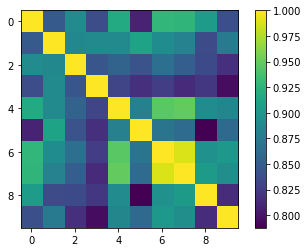

In [121]:
plt.imshow(x@x.T)
plt.colorbar()